## Set up directories

In [1]:
import os

labelbox_dir = "./data/labelbox"
labelbox_clouds_dir = f'{labelbox_dir}/clouds'
labelbox_clouds_rgb_dir = f'{labelbox_clouds_dir}/rgb'
labelbox_clouds_labels_dir = f'{labelbox_clouds_dir}/labels'
labelbox_clouds_source_dir = f'{labelbox_clouds_dir}/source'

labelbox_clouds_temp_dir = f'{labelbox_clouds_dir}/temp'

os.makedirs(labelbox_clouds_labels_dir, exist_ok=True)
os.makedirs(labelbox_clouds_rgb_dir, exist_ok=True)
os.makedirs(labelbox_clouds_source_dir, exist_ok=True)
os.makedirs(labelbox_clouds_temp_dir, exist_ok=True)

state_path = "./data/labelbox/clouds/uploadState"


In [2]:

try:
    from common.sagemaker_env import LABELBOX_API_KEY
except: 
    LABELBOX_API_KEY = os.environ['LABELBOX_API_KEY']
    
CLOUD_PROJECT_ID = "cleamnf3q398707ug5s2z4rp6"


## Create chips from bounding box and dates

In [4]:
%reload_ext autoreload
%autoreload 2

import multiprocessing
import numpy as np
from patchify import patchify
import rasterio
import rasterio.transform

from common.constants import NODATA_BYTE, NODATA_FLOAT32, RES, S2_BANDS_TIFF_ORDER
import common.utilities.download as download
import common.utilities.imagery as imagery

PATCH_SIZE = 512


def create_chips_from_bbox(bbox, start_date, end_date):
    
    collection_path = f'{labelbox_clouds_temp_dir}/collection.json'
    collection = download.get_collection(start_date, end_date, bbox, collection_path, max_cloud_cover=100, max_tile_count=1, min_tile_count=1)
    original_scenes = download.download_collection(collection, bbox, S2_BANDS_TIFF_ORDER, labelbox_clouds_temp_dir, RES)

    for scene in original_scenes:
        print(f'\tpatchifying... {scene}')
        
        stack_path = original_scenes[scene]["stack_original_tif_path"]
        with rasterio.open(stack_path) as src:
            if src.width < 512 or src.height < 512:
                print(f'\t\tskipping... {scene}')
                continue

        bbox_str = ''.join([str(round(coord, 2)) for coord in bbox]).replace('.', '').replace('-', 'n')
            
        with rasterio.open(stack_path) as src:
            stack_data = src.read().transpose((1, 2, 0))
            transform = src.transform

            source_patches = patchify(stack_data, (PATCH_SIZE, PATCH_SIZE, stack_data.shape[2]), step=PATCH_SIZE)
            
            for irow in range(source_patches.shape[0]):
                for icol in range(source_patches.shape[1]):
                    source_data = source_patches[irow, icol, 0, :, :, :]
                    
                    rgb_data = source_data[:, :, [2, 1, 0]]
                    rgb_data_norm = (rgb_data * 254).astype(np.uint8)
                    rgb_data_norm[rgb_data_norm > 254] = 254
        
                    rgb_path = f'{labelbox_clouds_rgb_dir}/{scene}_{bbox_str}_{irow}_{icol}.tif'
                    source_path = f'{labelbox_clouds_source_dir}/{scene}_{bbox_str}_{irow}_{icol}.tif'
                    
                    x_min, y_min = rasterio.transform.xy(transform, PATCH_SIZE*(irow+1), PATCH_SIZE*icol)
                    x_max, y_max = rasterio.transform.xy(transform, PATCH_SIZE*irow, PATCH_SIZE*(icol+1))             
                    chip_bbox = [x_min, y_min, x_max, y_max]
                                        
                    imagery.write_array_to_tif(source_data, source_path, chip_bbox, dtype=np.float32, nodata=NODATA_FLOAT32)
                    imagery.write_array_to_tif(rgb_data_norm, rgb_path, chip_bbox, dtype=np.uint8, nodata=NODATA_BYTE, is_cog=True)                        
                    

/var/lang/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import common.constants as constants
import common.aws.s3 as s3_utils


def save_rgb_chip_to_s3(rgb_path):
    file_name = rgb_path.split('/')[-1]    
    object_key = f'training/clouds/rgb/{file_name}'
    href = f'https://data.smartcarte.earth/{object_key}'
    s3_utils.put_item(rgb_path, constants.S3_DATA_BUCKET, object_key)
    return href


In [6]:
import datetime
from labelbox import Client, Dataset, DataRow
import glob
import os
import shelve



client = Client(api_key=LABELBOX_API_KEY)
project = client.get_project(CLOUD_PROJECT_ID)


def create_labelbox_dataset(prefix=""):
    
    today = datetime.datetime.today().strftime('%Y%m%d_%H%M')
    clouds_dataset_name = f"Clouds {prefix} {today}"
    
    clouds_dataset = client.get_datasets(where=(Dataset.name==clouds_dataset_name)).get_one()
    if clouds_dataset is not None:
        raise ValueError("cloud dataset already exists; wait a minute")        

    rgb_paths = glob.glob(f'{labelbox_clouds_rgb_dir}/*[0-9].tif')
    print(f'{len(rgb_paths)} total chips')
        
    with shelve.open(state_path) as upload_state:
        
        payload = []
        for rgb_path in rgb_paths:
            chip_id = rgb_path.split('/')[-1].replace('.tif', '')
            chip_state = upload_state.get(chip_id)
            
            if chip_state and chip_state.get('uploaded_to_labelbox', False):
                continue
            
            s3_href = save_rgb_chip_to_s3(rgb_path)
            
            payload.append({
                "chip_id": chip_id,
                "min_zoom": 10,
                "max_zoom": 16,
                "tile_layer_url": s3_href
            })

            upload_state[chip_id] = {
                'rgb_cog_href': s3_href,
                'uploaded_to_s3': True,
                'uploaded_to_labelbox': False
            }
                    
        if len(payload) > 0:
            print(f'{len(payload)} chips to add to Labelbox')

            clouds_dataset = client.create_dataset(name=clouds_dataset_name)
            datarow_payload = [{DataRow.row_data: row} for row in payload]
            task = clouds_dataset.create_data_rows(datarow_payload)
            task.wait_till_done()

            for row in payload:
                chip_id = row["chip_id"]
                upload_state[chip_id] = {
                    'rgb_cog_href': s3_href,
                    'uploaded_to_s3': True,
                    'uploaded_to_labelbox': True
                }
            

# Create new chips 🐿️🐿️🐿️

In [7]:
import shutil


def create_new_chips(bbox, region_name, dates):
    for date in dates:
        start_date, end_date = date[0], date[1]
        create_chips_from_bbox(bbox, start_date, end_date)
        
    create_labelbox_dataset(prefix=region_name)
    
    
def clean_up():
    if os.path.exists(labelbox_clouds_temp_dir):
        shutil.rmtree(labelbox_clouds_temp_dir)
        os.makedirs(labelbox_clouds_temp_dir, exist_ok=True)



In [8]:
import datetime as dt

dates = [
    (dt.datetime(2019, 1, 1), dt.datetime(2019, 2, 1)),
    (dt.datetime(2020, 3, 1), dt.datetime(2020, 4, 1)),
    (dt.datetime(2021, 6, 1), dt.datetime(2021, 7, 1)),
    (dt.datetime(2022, 9, 1), dt.datetime(2022, 10, 1)),
]


## Boma National Park 🐘

In [58]:
import datetime as dt

bbox_boma = [33.494145, 6.592713, 33.730720, 6.753140]
create_new_chips(bbox_boma, "Boma", dates)
clean_up()

print('done')

./data/labelbox/clouds/temp/collection.json: {'WN': 1}
	downloading... S2A_36NWN_20190115_0_L2A
	patchifying... S2A_36NWN_20190115_0_L2A
./data/labelbox/clouds/temp/collection.json: {'WN': 1}
	downloading... S2B_36NWN_20200325_0_L2A
	patchifying... S2B_36NWN_20200325_0_L2A
./data/labelbox/clouds/temp/collection.json: {'WN': 1}
	downloading... S2B_36NWN_20210608_0_L2A
	patchifying... S2B_36NWN_20210608_0_L2A
./data/labelbox/clouds/temp/collection.json: {'WN': 1}
	downloading... S2A_36NWN_20220906_0_L2A
	patchifying... S2A_36NWN_20220906_0_L2A
60 total chips
60 chips to add to Labelbox
done


## Virunga National Park (Gorilla Sector) 🦍

In [59]:
import datetime as dt

bbox_virunga_gorilla_sector = [29.397261, -1.464377, 29.55281, -1.366300]
create_new_chips(bbox_virunga_gorilla_sector, "Virunga Gorilla Sector", dates)
clean_up()

print('done')

./data/labelbox/clouds/temp/collection.json: {'QU': 1}
	downloading... S2B_35MQU_20190123_0_L2A
	patchifying... S2B_35MQU_20190123_0_L2A
./data/labelbox/clouds/temp/collection.json: {'QU': 1}
	downloading... S2A_35MQU_20200323_0_L2A
	patchifying... S2A_35MQU_20200323_0_L2A
./data/labelbox/clouds/temp/collection.json: {'QU': 1}
	downloading... S2B_35MQU_20210611_0_L2A
	patchifying... S2B_35MQU_20210611_0_L2A
./data/labelbox/clouds/temp/collection.json: {'QU': 1}
	downloading... S2A_35MQU_20220929_0_L2A
	patchifying... S2A_35MQU_20220929_0_L2A
84 total chips
24 chips to add to Labelbox
done


## Virunga National Park (Volcano Sector) 🌋

In [60]:
import datetime as dt

bbox_volcano = [29.037465, -1.445036, 29.364781, -1.217466]
create_new_chips(bbox_volcano, "Virunga Volcano Sector", dates)
clean_up()

print('done')

./data/labelbox/clouds/temp/collection.json: {'QU': 1}
	downloading... S2B_35MQU_20190123_0_L2A
	patchifying... S2B_35MQU_20190123_0_L2A
./data/labelbox/clouds/temp/collection.json: {'QU': 1}
	downloading... S2A_35MQU_20200323_0_L2A
	patchifying... S2A_35MQU_20200323_0_L2A
./data/labelbox/clouds/temp/collection.json: {'QU': 1}
	downloading... S2B_35MQU_20210611_0_L2A
	patchifying... S2B_35MQU_20210611_0_L2A
./data/labelbox/clouds/temp/collection.json: {'QU': 1}
	downloading... S2A_35MQU_20220929_0_L2A
	patchifying... S2A_35MQU_20220929_0_L2A
196 total chips
112 chips to add to Labelbox
done


## Virunga Central Sector 🦛

In [64]:
import datetime as dt

bbox_virunga_central_sector = [29.258226, -0.760528, 29.545592, -0.583160]
create_new_chips(bbox_virunga_central_sector, "Virunga Central Sector", dates)
clean_up()

print('done')

./data/labelbox/clouds/temp/collection.json: {'QV': 1}
	downloading... S2B_35MQV_20190123_0_L2A
	patchifying... S2B_35MQV_20190123_0_L2A
./data/labelbox/clouds/temp/collection.json: {'QV': 1}
	downloading... S2A_35MQV_20200303_0_L2A
	patchifying... S2A_35MQV_20200303_0_L2A
./data/labelbox/clouds/temp/collection.json: {'QV': 1}
	downloading... S2B_35MQV_20210611_0_L2A
	patchifying... S2B_35MQV_20210611_0_L2A
./data/labelbox/clouds/temp/collection.json: {'QV': 1}
	downloading... S2A_35MQV_20220929_0_L2A
	patchifying... S2A_35MQV_20220929_0_L2A
324 total chips
72 chips to add to Labelbox
done


## Goma 🏙️

In [62]:
import datetime as dt

bbox_goma = [29.084695, -1.708073, 29.310951, -1.605942]
create_new_chips(bbox_goma, "Goma", dates)
clean_up()

print('done')

./data/labelbox/clouds/temp/collection.json: {'QU': 1}
	downloading... S2B_35MQU_20190123_0_L2A
	patchifying... S2B_35MQU_20190123_0_L2A
./data/labelbox/clouds/temp/collection.json: {'QU': 1}
	downloading... S2A_35MQU_20200323_0_L2A
	patchifying... S2A_35MQU_20200323_0_L2A
./data/labelbox/clouds/temp/collection.json: {'QU': 1}
	downloading... S2B_35MQU_20210611_0_L2A
	patchifying... S2B_35MQU_20210611_0_L2A
./data/labelbox/clouds/temp/collection.json: {'QU': 1}
	downloading... S2A_35MQU_20220929_0_L2A
	patchifying... S2A_35MQU_20220929_0_L2A
228 total chips
32 chips to add to Labelbox
done


## Zakouma National Park 🦒

In [63]:
import datetime as dt

bbox_zakouma = [19.742523, 10.831293, 19.903319, 10.960331]
create_new_chips(bbox_zakouma, "Zakouma", dates)
clean_up()

print('done')

./data/labelbox/clouds/temp/collection.json: {'CT': 1, 'CS': 1}
	downloading... S2A_34PCT_20190123_1_L2A
	downloading... S2A_34PCS_20190123_0_L2A
	patchifying... S2A_34PCT_20190123_1_L2A
	patchifying... S2A_34PCS_20190123_0_L2A
		skipping... S2A_34PCS_20190123_0_L2A
./data/labelbox/clouds/temp/collection.json: {'CT': 1, 'CS': 1}
	downloading... S2B_34PCT_20200303_0_L2A
	downloading... S2B_34PCS_20200323_0_L2A
	patchifying... S2B_34PCT_20200303_0_L2A
	patchifying... S2B_34PCS_20200323_0_L2A
		skipping... S2B_34PCS_20200323_0_L2A
./data/labelbox/clouds/temp/collection.json: {'CS': 1, 'CT': 1}
	downloading... S2B_34PCS_20210626_0_L2A
	downloading... S2B_34PCT_20210626_0_L2A
	patchifying... S2B_34PCS_20210626_0_L2A
		skipping... S2B_34PCS_20210626_0_L2A
	patchifying... S2B_34PCT_20210626_0_L2A
./data/labelbox/clouds/temp/collection.json: {'CT': 1, 'CS': 1}
	downloading... S2B_34PCT_20220919_0_L2A
	downloading... S2B_34PCS_20220919_0_L2A
	patchifying... S2B_34PCT_20220919_0_L2A
	patchifying

## Dzanga-Sangha / Nouabale-Ndoki 🐒

In [39]:

bbox_dzanga = [16.095076, 2.260259, 16.240427, 2.494004]
create_new_chips(bbox_dzanga, "Dzanga", dates)
clean_up()

print('done')

./data/labelbox/clouds/temp/collection.json: {'XC': 1}
	downloading... S2B_33NXC_20190111_0_L2A
	patchifying... S2B_33NXC_20190111_0_L2A
./data/labelbox/clouds/temp/collection.json: {'XC': 1}
	downloading... S2A_33NXC_20200331_0_L2A
	patchifying... S2A_33NXC_20200331_0_L2A
./data/labelbox/clouds/temp/collection.json: {'XC': 1}
	downloading... S2B_33NXC_20210609_0_L2A
	patchifying... S2B_33NXC_20210609_0_L2A
./data/labelbox/clouds/temp/collection.json: {'XC': 1}
	downloading... S2A_33NXC_20220907_0_L2A
	patchifying... S2A_33NXC_20220907_0_L2A
404 total chips
80 chips to add to Labelbox
done


## Maldives 🏝️

In [9]:
import datetime as dt

bbox_maldives = [73.429215, 0.507726, 73.570819, 0.600169]
create_new_chips(bbox_maldives, "Maldives", dates)
clean_up()

print('done')

./data/labelbox/clouds/temp/collection.json: {'CA': 1}
	downloading... S2A_43NCA_20190127_0_L2A
	patchifying... S2A_43NCA_20190127_0_L2A
./data/labelbox/clouds/temp/collection.json: {'CA': 1}
	downloading... S2A_43NCA_20200302_0_L2A
	patchifying... S2A_43NCA_20200302_0_L2A
./data/labelbox/clouds/temp/collection.json: {'CA': 1}
	downloading... S2A_43NCA_20210615_0_L2A
	patchifying... S2A_43NCA_20210615_0_L2A
./data/labelbox/clouds/temp/collection.json: {'CA': 1}
	downloading... S2B_43NCA_20220913_0_L2A
	patchifying... S2B_43NCA_20220913_0_L2A
24 total chips
24 chips to add to Labelbox
done


## Philippines 🐠

In [10]:
import datetime as dt

bbox_phil = [120.854117, 11.074217, 121.191643, 11.314941]
create_new_chips(bbox_phil, "Philippines", dates)
clean_up()

print('done')

./data/labelbox/clouds/temp/collection.json: {'UN': 1, 'TN': 1}
	downloading... S2B_51PUN_20190108_0_L2A
	downloading... S2A_51PTN_20190113_0_L2A
	patchifying... S2B_51PUN_20190108_0_L2A
		skipping... S2B_51PUN_20190108_0_L2A
	patchifying... S2A_51PTN_20190113_0_L2A
./data/labelbox/clouds/temp/collection.json: {'UN': 1, 'TN': 1}
	downloading... S2A_51PUN_20200318_0_L2A
	downloading... S2B_51PTN_20200323_0_L2A
	patchifying... S2A_51PUN_20200318_0_L2A
		skipping... S2A_51PUN_20200318_0_L2A
	patchifying... S2B_51PTN_20200323_0_L2A
./data/labelbox/clouds/temp/collection.json: {'TN': 1, 'UN': 1}
	downloading... S2B_51PTN_20210616_0_L2A
	downloading... S2B_51PUN_20210626_0_L2A
	patchifying... S2B_51PTN_20210616_0_L2A
	patchifying... S2B_51PUN_20210626_0_L2A
		skipping... S2B_51PUN_20210626_0_L2A
./data/labelbox/clouds/temp/collection.json: {'UN': 1, 'TN': 1}
	downloading... S2B_51PUN_20220919_0_L2A
	downloading... S2B_51PTN_20220909_0_L2A
	patchifying... S2B_51PUN_20220919_0_L2A
		skipping..

### Delete some scenes from uploadState

In [31]:
import re
import shelve

    
with shelve.open(state_path) as upload_state:
    
    keys = list(upload_state.keys())
    for key in keys:
        if re.match(r'^(S2A_33NWC|S2B_33NWC|S2A_33NXC|S2B_33NXC)', key):
            del upload_state[key]


In [38]:
import glob
import os

bad_files = glob.glob(f'{labelbox_clouds_rgb_dir}/S2B_33NWC*')
print(len(bad_files))
for fp in bad_files:
    os.remove(fp)


0


## Add old data to new Labelbox flow

In [11]:
import glob
import os
import shutil


old_source_paths = glob.glob('./data/mergedCloudTrainingData/original/source/S2*[0-9].tif')

print(f'copying {len(old_source_paths)} old chips')
for old_path in old_source_paths:
    file_name = old_path.split('/')[-1]
    new_path = f'{labelbox_clouds_source_dir}/{file_name}'
    shutil.copy2(old_path, new_path)

print('done')

copying 118 old chips


## Pull labeled data from Labelbox

In [13]:
from labelbox import Client


def get_data_rows():
    client = Client(api_key=LABELBOX_API_KEY)
    project = client.get_project(CLOUD_PROJECT_ID)
    data_rows = project.export_labels(download=True)  
    return data_rows


def is_island(target_polygon, polygon_list):
    for curr_poly in polygon_list:
        if target_polygon.within(curr_poly):
            return True
    return False


In [22]:
import json
import numpy as np
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import Polygon

from common.constants import NODATA_BYTE
from common.utilities.imagery import write_array_to_tif


CLOUD_CLASSES = {
    'no_cloud': 0,
    'cloud': 1
}

data_rows = get_data_rows()
data_rows = [dr for dr in data_rows if dr['DataRow Workflow Info']['taskName'] == "Done"]
print(f'{len(data_rows)} done data rows')

for i, row in enumerate(data_rows):
        
    row_id = row['DataRow ID']    
    labels = row['Label']['objects']
    metadata = json.loads(row['Labeled Data'])
    rgb_cog_url = metadata['tileLayerUrl']
    file_name = rgb_cog_url.split('/')[-1]
        
    rgb_path = f'{labelbox_clouds_rgb_dir}/{file_name}'
    label_path = f'{labelbox_clouds_labels_dir}/{file_name}'
    source_path = f'{labelbox_clouds_source_dir}/{file_name}'

    with rasterio.open(source_path) as src:
        bbox = list(src.bounds)
        source_shape = src.shape
        source_transform = src.transform
    
    label_polygons = {
        label['featureId']: Polygon(label['geometry']['coordinates'][0])
        for label in labels
    }
        
    # 0: no_cloud, 1: cloud
    labels_data = np.zeros(source_shape).astype(np.uint8)
    
    islands = []    
    sorted_labels = sorted(labels, key=lambda lab: lab['value'], reverse=True)   
    for label in sorted_labels:
        class_value = label['value']
        class_idx = CLOUD_CLASSES[class_value]
                
        label_id = label['featureId']
        polygon = label_polygons[label_id]
        polygon_mask = geometry_mask([polygon], source_shape, source_transform, invert=True)
        
        test_polygons = label_polygons.copy()
        del test_polygons[label_id]
        is_poly_island = is_island(polygon, list(test_polygons.values()))
                
        if is_poly_island:
            islands.append((class_idx, polygon_mask))
        else:
            labels_data[polygon_mask] = class_idx

    for class_idx, polygon_mask in islands:
        labels_data[polygon_mask] = class_idx
          
    write_array_to_tif(labels_data, label_path, bbox, dtype=np.uint8, nodata=NODATA_BYTE)
       

print('done')

118 done data rows
done


# Data augmentation ⚒️
### Rotate images 90 degrees

In [26]:
%reload_ext autoreload
%autoreload 2

import glob
import numpy as np
import rasterio
import shutil

from common.constants import NODATA_BYTE, NODATA_FLOAT32
import common.utilities.imagery as imagery


label_paths = glob.glob(f'{labelbox_clouds_labels_dir}/S2*[0-9].tif')

for label_path in label_paths:
    
    source_path = label_path.replace(labelbox_clouds_labels_dir, labelbox_clouds_source_dir)
                        
    with rasterio.open(source_path) as source_src:
        source_data = source_src.read()
        bbox = list(source_src.bounds)
        
    with rasterio.open(label_path) as label_src:
        label_data = label_src.read(1)
                  
    source_rotated = np.rot90(source_data, k=1, axes=(1, 2))
    source_rotated = source_rotated.transpose((1, 2, 0))

    label_rotated = np.rot90(label_data, k=1, axes=(0, 1))

    source_rotated_path = source_path.replace('.tif', f'_90deg.tif')
    label_rotated_path = label_path.replace('.tif', f'_90deg.tif')

    imagery.write_array_to_tif(source_rotated, source_rotated_path, bbox, dtype=np.float32, nodata=NODATA_FLOAT32)
    imagery.write_array_to_tif(label_rotated, label_rotated_path, bbox, dtype=np.uint8, nodata=NODATA_BYTE)     

print('done')

done


## Add nodata

In [27]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import random
import rasterio

from common.constants import NODATA_BYTE, NODATA_FLOAT32
import common.utilities.imagery as imagery
from common.utilities.visualization import plot_bands


random.seed(666)

# get non-augmented labeled chips
label_paths = glob.glob(f'{labelbox_clouds_labels_dir}/S2*[0-9].tif')

for i, label_path in enumerate(label_paths):
    
    if i % 50 == 0:
        print(f'{i} done')

    source_path = label_path.replace(labelbox_clouds_labels_dir, labelbox_clouds_source_dir)
                
    with rasterio.open(source_path) as source_src:
        source_data = source_src.read()
        bbox = list(source_src.bounds)
        mask_shape = source_src.shape
        
    with rasterio.open(label_path) as label_src:
        label_data = label_src.read(1)
        
    source_nodata_path = source_path.replace('.tif', f'_nodata.tif')
    label_nodata_path = label_path.replace('.tif', f'_nodata.tif')

    mask = np.zeros(mask_shape, dtype=bool)
    
    # simulate cut off scene
    if i % 50 == 0:
        minp, maxp = 200, 300 
        padding = random.randint(minp, maxp)
        mask[:, -padding:] = True
    else:
        minp, maxp = 4, 24
        pb = random.randint(minp, maxp)
        pl = random.randint(minp, maxp)
        pt = random.randint(minp, maxp)
        pr = random.randint(minp, maxp)
        mask[-pb:, :] = True
        mask[:, :pl] = True
        mask[:pt, :] = True
        mask[:, -pr:] = True
        
    source_data[:, mask] = NODATA_FLOAT32
    source_data = source_data.transpose((1, 2, 0))
    label_data[mask] = 0 # no clouds
    
    imagery.write_array_to_tif(source_data, source_nodata_path, bbox, dtype=np.float32, nodata=NODATA_FLOAT32)
    imagery.write_array_to_tif(label_data, label_nodata_path, bbox, dtype=np.uint8, nodata=NODATA_BYTE)     
    
print('done')

0 done
50 done
100 done


## Test plot

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


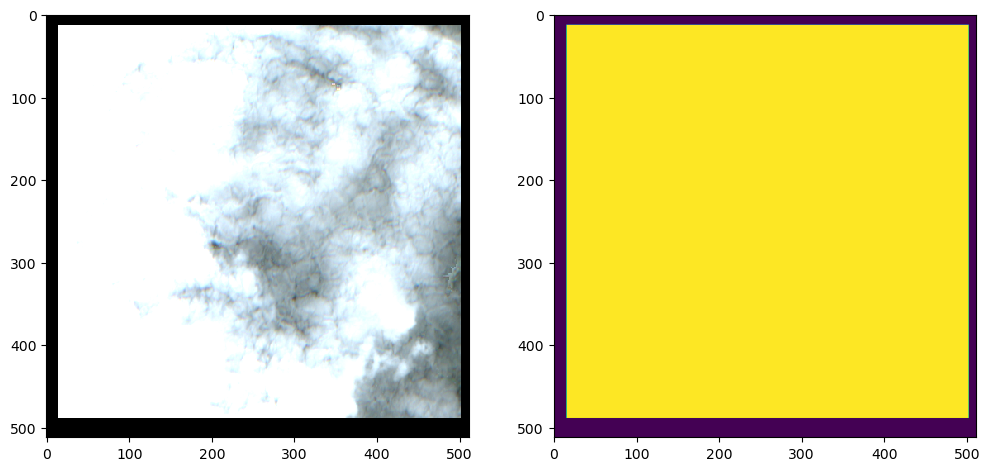

In [29]:
import matplotlib.pyplot as plt

from common.utilities.visualization import plot_bands


label_path = './data/labelbox/clouds/labels/S2A_35MRU_20220122_0_L2A_2_0_nodata.tif'
source_path = './data/labelbox/clouds/source/S2A_35MRU_20220122_0_L2A_2_0_nodata.tif'


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))

with rasterio.open(source_path) as src:
    source_data = src.read()
    plot_bands(source_data, ax=ax1, bands=[2, 1, 0], transpose=True)

with rasterio.open(label_path) as src:
    label_data = src.read(1)
    ax2.imshow(label_data)
    

# Radiant Earth

In [ ]:

re_cloud_dir = "./data/radiantEarth/clouds"


In [ ]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import os
from pystac_client import Client
import rasterio
import requests
import shutil

from common.constants import NODATA_FLOAT32
from common.sagemaker_env import RADIANT_EARTH_API_KEY
import common.utilities.imagery as imagery


client = Client.open("https://api.radiant.earth/mlhub/v1", parameters={"key": RADIANT_EARTH_API_KEY})

collections = [
        'ref_cloud_cover_detection_challenge_v1_train_source',
        'ref_cloud_cover_detection_challenge_v1_train_labels',
        'ref_cloud_cover_detection_challenge_v1_test_source',
        'ref_cloud_cover_detection_challenge_v1_test_labels',
]


for collection_id in collections:

    role = collection_id.split('_')[-1]
    stage = collection_id.split('_')[-2]
    items_dir = f'{re_cloud_dir}/{role}'
    os.makedirs(items_dir, exist_ok=True)

    print(collection_id, items_dir)
    
    collection = client.get_collection(collection_id)
    results = collection.get_items()
        
    for i, item in enumerate(results):

        chip_id = item.id.split('_')[-1] # chip_id
        chip_path = f'{items_dir}/{chip_id}.tif'
        chip_90deg_path = f'{items_dir}/{chip_id}_90deg.tif'

        if i % 50 == 0:
            print(f'\t{i} chips done')
                        
        if os.path.exists(chip_path):
            # rotate images 90 degrees
            if not os.path.exists(chip_90deg_path):
                with rasterio.open(chip_path) as src:
                    bbox = list(src.bounds)
                    if role == "source":
                        data = src.read()
                        data_90deg = np.rot90(data, axes=(1, 2)).transpose((1, 2, 0))
                        imagery.write_array_to_tif(data_90deg, chip_90deg_path, bbox, dtype=np.float32, nodata=NODATA_FLOAT32)
                    elif role == "labels":
                        data = src.read(1)
                        data_90deg = np.rot90(data, axes=(0, 1))
                        imagery.write_array_to_tif(data_90deg, chip_90deg_path, bbox, dtype=np.uint8, nodata=255)
                        
            continue
            
        while True:
            try:
                if role == "labels":
                    asset_href = item.assets['raster_labels'].href
                    response = requests.get(asset_href)
                    with open(chip_path, 'wb') as f:
                        f.write(response.content)

                else:
                    temp_dir = f'{items_dir}/{chip_id}_temp'
                    os.makedirs(temp_dir, exist_ok=True)
                    
                    band_paths = []
                    for band in item.assets:
                        band_path = f'{temp_dir}/{band}.tif'                
                        band_paths.append(band_path)
                        band_href = item.assets[band].href
                        response = requests.get(band_href)
                        with open(band_path, 'wb') as f:
                            f.write(response.content)
                                                        
                    stack_data = []
                    bbox, epsg = None, 4326
                    for path in band_paths:
                        with rasterio.open(path) as src:
                            stack_data.append(src.read(1))
                            bbox = list(src.bounds)
                            epsg = src.crs.to_epsg()                       
                                                        
                    stack_data = np.array(stack_data).astype(np.float32)
                    stack_data = imagery.normalize_original_s2_array(stack_data)
                    stack_data = stack_data.transpose((1, 2, 0))
                    imagery.write_array_to_tif(stack_data, chip_path, bbox, dtype=np.float32, epsg=epsg, nodata=NODATA_FLOAT32) 
                                
                    shutil.rmtree(temp_dir)
                    
                break
                    
            except Exception as e:
                print('error:', e)
                raise
                
print('done')

# Merge everything together

In [ ]:

merged_original_dir = "./data/mergedCloudTrainingData/original"
merged_split_dir = "./data/mergedCloudTrainingData/split"


In [ ]:
import glob
import multiprocessing
import os
import shutil


if os.path.exists(merged_original_dir):
    shutil.rmtree(merged_original_dir)

os.makedirs(f'{merged_original_dir}/source', exist_ok=True)
os.makedirs(f'{merged_original_dir}/labels', exist_ok=True)
os.makedirs(merged_split_dir, exist_ok=True)


def process_label_path(path):
    file_name = path.split('/')[-1]
    dst_path = f'{merged_original_dir}/labels/{file_name}'
    shutil.copy2(path, dst_path)

def process_source_path(path):
    file_name = path.split('/')[-1]
    dst_path = f'{merged_original_dir}/source/{file_name}'
    shutil.copy2(path, dst_path)

    
all_cloud_dirs = [labelbox_clouds_dir, re_cloud_dir]    
for _dir in all_cloud_dirs:
    
    label_paths = glob.glob(f'{_dir}/labels/*.tif')
    print(f'{_dir}: {len(label_paths)} label paths')
    
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        pool.map(process_label_path, label_paths)

    # ensure that every label has source, otherwise throws exception
    source_paths = [p.replace('/labels/', '/source/') for p in label_paths]
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        pool.map(process_source_path, source_paths)

print('done')